<a href="https://colab.research.google.com/github/moimigueldev/tensorflow-ztm/blob/main/tensorflow/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow part3: Scaling Up -> Food Vision Mini

We've seen the power of transfer leraning feature extractions, fine tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of 
food)

Our goal is to beat the original Food101 paper with 10% of the training data (levaraging the power of deep learning)

[Original Food 101 Paper (PDF)](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)

Our baseline to beat is 50.76% accuracy across 101 classes.



In [1]:
# Check to see. if we're using a GPU
!nvidia-smi

Fri Jun 10 20:29:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created a series of helper functions to do different task. 
Lets download them

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-10 20:29:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-10 20:29:38 (94.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food 101 paper with 10% of the trainig data, so let's download it

The data we're downloading comes from the origina Food101 dataset but has been preprocessed using the image_data_modification notebook 

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

train_dir = '101_food_classes_10_percent/train/'
test_dir = '101_food_classes_10_percent/test/'

--2022-06-10 20:29:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.251.8.128, 2404:6800:4008:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   100MB/s    in 16s     

2022-06-10 20:29:59 (98.0 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# walk_through_dir('101_food_classes_10_percent')

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(244, 244)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  label_mode='categorical',
  image_size=IMG_SIZE,
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode='categorical',
  image_size=IMG_SIZE,
  shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the big seps we're going to take:

* Create a ModelCheckpoint callback
* Create a daga augmentation layer to build data augmentation into the model
* Build a headless (no top layers) Functional EfficientNetB0 backbone model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and we'll validate on only 15% of test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path ,
    save_weights_only=True ,
    save_best_only=True,
    monitor='val_accuracy',
)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  # preprocessing.Rescaling(1/255.),
], name='data_augmentation')

In [9]:
# Setup the base model and freeze its layers (this will extract features)
input_shape=IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name='input_layer')

x = data_augmentation(inputs) # This only happens during training face

x = base_model(x, training=False) # Put the base_model in infrence mode so weights which need to tay frozen, stay frozen

x = layers.GlobalAveragePooling2D(name='average_pool_layer')(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)



16719872/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 244, 244, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 average_pool_layer (GlobalA  (None, 1280)             0         
 veragePooling2D)                                                
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [11]:
# Compile & Fit
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history_all_classes_10_percent = model.fit(
  train_data_all_10_percent,
  epochs=5,
  steps_per_epoch=len(train_data_all_10_percent),
  validation_data =test_data,
  validation_steps=int(0.15 * len(test_data)),
  callbacks=[checkpoint_callback]
)


Epoch 1/5
237/237 [==============================] - 60s 184ms/step - loss: 3.4571 - accuracy: 0.2528 - val_loss: 2.6400 - val_accuracy: 0.4076
Epoch 2/5
237/237 [==============================] - 37s 154ms/step - loss: 2.3278 - accuracy: 0.4677 - val_loss: 2.1763 - val_accuracy: 0.4759
Epoch 3/5
237/237 [==============================] - 35s 145ms/step - loss: 1.9522 - accuracy: 0.5417 - val_loss: 2.0163 - val_accuracy: 0.4894
Epoch 4/5
237/237 [==============================] - 34s 144ms/step - loss: 1.7317 - accuracy: 0.5820 - val_loss: 1.9262 - val_accuracy: 0.5013
Epoch 5/5
237/237 [==============================] - 32s 133ms/step - loss: 1.5708 - accuracy: 0.6231 - val_loss: 1.8813 - val_accuracy: 0.5056


In [12]:
# Evaluate the model 
feature_extraction_results = model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 1.6563 - accuracy: 0.5680


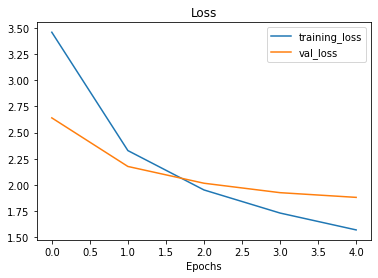

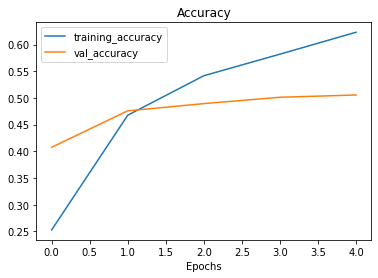

In [13]:
plot_loss_curves(history_all_classes_10_percent)

**Question:** What do these curves suggest? Hint: Ideally curves should be pretty close to each other, if not then that means the model is overfitted to the traiing data

## Fine Tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [15]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [16]:
# What layers in the model is trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
average_pool_layer True
dense True


In [17]:
# Check wich layers are trainalbe in our base_model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Fine tune for 5 more epocs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), This is the total number of epochs were' after 

# Fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent,
    epochs=fine_tune_epochs,
    validation_data= test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_all_classes_10_percent.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 39s 138ms/step - loss: 1.3268 - accuracy: 0.6582 - val_loss: 1.8340 - val_accuracy: 0.5183
Epoch 6/10
 73/237 [========>.....................] - ETA: 16s - loss: 1.2520 - accuracy: 0.6738

In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)

In [ ]:
# Compare the histories of feature extraction model with fine tuning model
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune, 5)

# Saving and loading our model

To use our model in external model in an external application, we'll need to save it and export it somewhere

In [ ]:
model.save()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('/content/drive/MyDrive/saved_models/tensorflow/101_food_classes_10_percent')

In [ ]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/tensorflow/101_food_classes_10_percent')

In [ ]:
# Evaluate loaded model and comeare performace to presaved model
loaded_models_results = loaded_model.evaluate(test_data)
loaded_models_results



In [ ]:
# The results from the model above should be similar
all_classes_10_percent_fine_tune_results